# CNN Model - Data Visualizations

In [325]:
# Load packages
import csv
import math
import numpy as np
import os
import pandas as pd
import random

from datetime import datetime as dt
from matplotlib import pyplot as plt
from PIL import Image

## Variables and Hyperparameters

In [339]:
###############
## VARIABLES ##
###############

# name of directory with fire tif files
tif_directory = "toydata"

# name of directory with weather data
weather_directory = 'weather_data'

# name of fire direction file
direction_file = 'Global_fire_atlas_dircrop'

# name of fire speed file
speed_file = 'Global_fire_atlas_speedcrop'

# weather and fire data to include in model
rainint = True
raintot = False
high_t = True
low_t = True
humidity = True
wind_speed = True
wind_direction = True
cloud_cover = False
fire_direction = True
fire_speed = True

weather_variables = {
    'rainint': rainint, 
    'raintot': raintot, 
    'High T': high_t, 
    'Low T': low_t, 
    'Humidity': humidity, 
    'Wind Speed': wind_speed, 
    'Wind Direction': wind_direction, 
    'Cloud Cover': cloud_cover,
    'Fire Direction': fire_direction,
    'Fire Speed': fire_speed
}

weather_vars = []

for k, v in weather_variables.items():
    if v == True:
        weather_vars.append(k)

model_3 = None
        
#####################
## HYPERPARAMETERS ##
#####################

# scale the weather data - yea or nay
normalized_weather = True

# the desired height and width (in pixels) of the matrix to feed into the CNN
# 1 pixel side = 500 meters = 0.310686 miles
matrix_dim = 32

# multiplier for amount of zero-labeled data we want to add to dataset
labeled_multiplier = 24

# test size for train/test split
test_size = 0.2

# training epochs
epoc = 20

## Dataset Preprocessing Pipeline

### Fire Dataset Preprocessing Functions

In [340]:
def data_processing(directory):
    '''
    Process the dataset in the supplied directory and return matrices of which pixels belong to which fire and 
    which day of the year the pixel was on fire.
    
    Args: 
        - directory: name of directory with tif files
    Returns: 
        - fire_data_dict: a dictionary where the key is "fire_id" and the value is a matrix of pixels 
        triggered by that fire (0, 1)
        - fireline: matrix denoting what day of year that pixel was on fire (1-365)
    '''
    
    path = os.path.abspath(directory)

    tiff_files = []

    for f in os.listdir(path):
        if f.endswith('.tif'):
            tiff_files.append(path + '/' + f)

    tiff_dict = {}

    # dictionary of tiff files
    for f in tiff_files:
        k = f.split('/')[-1].split('.tif')[0]
        tiff_dict[k] = f

    # convert to np array
    fire_id = Image.open(tiff_dict['fireid'])
    fire_id = np.array(fire_id)
    fire_id[fire_id == -9999] = 0

    fireline = Image.open(tiff_dict['Global_fire_atlas_firelinecrop'])
    fireline = np.array(fireline)
    fireline[fireline == -9999] = 0

    # get list of unique fire_ids
    fire_ids = set()

    for row in fire_id:
        for val in row:
            fire_ids.add(val)

    # remove 0 from fire_ids set because it does not denote a fire
    fire_ids.remove(0)

    # get dict with key value pairs of fire_id and an empty dict
    fire_data_dict = {}

    for id in fire_ids:
        id = str(id)
        fire_data_dict[id] = {}

    for id in fire_ids:
        indices = np.where(fire_id == id, 1, 0)
        fire_data_dict[str(id)] = indices
        
    return fire_data_dict, fireline

In [341]:
def create_one_hot_matrices(data_dict, fireline):
    '''
    Create matrices for each fire_id that show were the fire was on a given day during the year.
    
    Args:
        - data_dict: a dictionary where the key is "fire_id" and the value is a matrix of pixels 
        triggered by that fire (0, 1)
        - fireline: matrix denoting what day of year that pixel was on fire (1-365)
    Returns:
        - fire_data_dict: a dictionary of the following structure:
            {
                "fire_id": {
                    "day_of_year": one-hot encoded 2D array of fire spread on that day,
                    "day_of_year": one-hot encoded 2D array of fire spread on that day
                }

            }
    '''
    
    fire_data_dict = {}

    for key, val in data_dict.items():
        data = {}
                
        for y in range(1, 366):
            mask = ((fireline == y) & (val == 1))
            mask = mask.astype(int)
        
            if np.sum(mask) > 0:
                data[str(y)] = mask
        
        fire_data_dict[key] = data
        
    return fire_data_dict

In [342]:
def create_day_pairs(fire_data_dict):
    '''
    Create a list of sets where the first value is where the fire was on a given day and the second value is where
    the fire was on the following day.
    
    Args:
        - fire_data_dict: a dictionary of the following structure:
            {
                "fire_id": {
                    "day_of_year": one-hot encoded 2D array of fire spread on that day,
                    "day_of_year": one-hot encoded 2D array of fire spread on that day
                }

            }
    Returns:
        - train_labels: a list of sets where the first value of the set is a one-hot encoded 2D array of fire 
        spread on day_1 and the second value of the set is a one-hot encoded 2D array of fire spread on day_2:
        [
            (one-hot encoded 2D array of fire spread on that day_1, one-hot encoded 2D array of fire spread on day_2),
            (one-hot encoded 2D array of fire spread on that day_2, one-hot encoded 2D array of fire spread on day_3),
        ]
    '''
    
    train_labels = []

    for key, value in fire_data_dict.items():
        burn_matrices = list(value.values())
        day_of_year = list(value.keys())
        
        for index, day in enumerate(burn_matrices):

            if index < len(burn_matrices) - 1:
                day_1 = burn_matrices[index]
                day_2_index = index + 1
                day_2 = burn_matrices[day_2_index]
                
                doy = day_of_year[day_2_index]
                
                pair = (day_1, day_2)
                train_labels.append((doy, pair))

    return train_labels

In [343]:
def process_fire_data_tiff(directory, file):
    '''
    Process the fire data in the supplied tiff file and return a dictionary of key day of year and value a matrix 
    making up the attribute of that tiff file

    Args:
        - directory: name of directory of supplemental data
        - file: name of tiff file of supplemental data to add to model
    Returns:
        - fire_data_dict: a dictionary where the key is "fire_id" and the value is a matrix of pixels 
        triggered by the attribute of interest
    '''
    
    path = os.path.abspath(directory)

    tiff_files = []

    for f in os.listdir(path):
        if f.endswith('.tif'):
            tiff_files.append(path + '/' + f)

    tiff_dict = {}

    # dictionary of tiff files
    for f in tiff_files:
        k = f.split('/')[-1].split('.tif')[0]
        tiff_dict[k] = f
        
    # convert day of burn tif to np array
    fire_dob = Image.open(tiff_dict['Global_fire_atlas_dobcrop'])
    fire_dob = np.array(fire_dob)
    fire_dob[fire_dob == -9999] = 0

    # convert tif of interest to np array
    fire_data_mat = Image.open(tiff_dict[file])
    fire_data_mat = np.array(fire_data_mat)
    fire_data_mat[fire_data_mat == -9999] = 0
    
    # get list of unique days of burn
    days_of_burn = list(np.unique(fire_dob))

    # remove 0 from days of burn because it does not denote a fire
    days_of_burn.remove(0)
        
    # get dict with key value pairs of fire_id and an empty dict
    fire_data_dict = {}

    for idx in days_of_burn:
        idx = int(idx)
        
        mask = (fire_dob == idx)        
        mask = mask.astype(int)
        
        values = np.multiply(mask, fire_data_mat)
        
        idx = str(idx)
        fire_data_dict[idx] = {}
        fire_data_dict[idx]['Fire Direction'] = values 

    
    return fire_data_dict

In [344]:
def process_fire_data_png(directory, file):
    '''
    Process the fire data in the supplied png file and return a dictionary of key day of year and value a matrix 
    making up the attribute of that png file

    Args:
        - directory: name of directory of supplemental data
        - file: name of png file of supplemental data to add to model
    Returns:
        - fire_data_dict: a dictionary where the key is "fire_id" and the value is a matrix of pixels 
        triggered by the attribute of interest
    '''
    
    path = os.path.abspath(directory)

    tiff_files = []
    png_files = []
    
    for f in os.listdir(path):
        if f.endswith('.tif'):
            tiff_files.append(path + '/' + f)

    for f in os.listdir(path):
        if f.endswith('.png'):
            png_files.append(path + '/' + f)
    
    tiff_dict = {}
    png_dict = {}

    # dictionary of tiff files
    for f in tiff_files:
        k = f.split('/')[-1].split('.tif')[0]
        tiff_dict[k] = f
    
    for f in png_files:
        k = f.split('/')[-1].split('.png')[0]
        png_dict[k] = f
        
    # convert day of burn tif to np array
    fire_dob = Image.open(tiff_dict['Global_fire_atlas_dobcrop'])
    fire_dob = np.array(fire_dob)
    fire_dob[fire_dob == -9999] = 0

    # convert png of interest to np array
    fire_data_mat = Image.open(png_dict[file])
    fire_data_mat = np.array(fire_data_mat)
    fire_data_mat[fire_data_mat == -9999] = 0
    
    # get list of unique days of burn
    days_of_burn = list(np.unique(fire_dob))

    # remove 0 from days of burn because it does not denote a fire
    days_of_burn.remove(0)
        
    # get dict with key value pairs of fire_id and an empty dict
    fire_data_dict = {}

    for idx in days_of_burn:
        idx = int(idx)
        
        mask = (fire_dob == idx)        
        mask = mask.astype(int)
        
        values = np.multiply(mask, fire_data_mat)
        
        idx = str(idx)
        fire_data_dict[idx] = {}
        fire_data_dict[idx]['Fire Speed'] = values 

    
    return fire_data_dict

In [345]:
def combine_dicts(dict_1, dict_2):
    '''
    A helper function to combine the values of two dictionaries that have the same keys.
    
    Args:
        - dict_1: a dictionary of key day of year, and value a dictionary of key fire attribute and value a matrix
        denoting where that attribute is triggered
        - dict_2: a dictionary of key day of year, and value a dictionary of key fire attribute and value a matrix
        denoting where that attribute is triggered
    Returns:
        - dict_2: combined dictionary of dict_1 and dict_2
    '''
      
    for k, v in dict_1.items():
        for att, mat in v.items():
            dict_2[k][att] = mat
            
    return dict_2

### Weather Data Preprocessing Functions

In [346]:
def create_weather_dict(directory, normalized_weather, weather_vars, fire_data_dict):
    '''
    Create a dictionary of weather data from a pickled file
    Args:
        - directory: path to weather pickle file
        - normalized_weather: True/False to scale using max value
        - weather_vars: list of weather variables to include in model
    Returns:
        - weather_data: dictionary of key (day of year) and value (dictionary of key (weather parameter) 
        and value (matrix of value for each pixel))
        - max_values: a list of max values for each weather feature to use to normalize data
    '''

    path = os.path.abspath(directory)
    
    weather_file = ''
    
    for f in os.listdir(path):
        if f.endswith('.pickle'):
            weather_file = path + '/' + f
    
    weather = pd.read_pickle(weather_file)
    
    weather_dict = {}
    
    for k, v in weather.items():
        weather_dict[k] = {}
        
        for att, matrix in v.items():
            if att in weather_vars:
                
                # scale to kelvin
                if att in ['High T', 'Low T']:
                    mat = np.nan_to_num(matrix)
                    mat += 273.15
                    weather_dict[k][att] = mat
                else:
                    mat = np.nan_to_num(matrix)
                    weather_dict[k][att] = mat
     
    weather_data = {}

    for k, v in weather_dict.items():
        doy = dt.strptime(k, "%Y-%m-%d").strftime("%j")
        weather_data[doy] = v
            
    # scale weather data
    vals = list(weather_data.values())[0]
    weather_atts = list(vals.keys())
    max_values = dict.fromkeys(weather_atts, 0)
    
    if normalized_weather == True:
        
        for k, v in weather_dict.items():

            for weather_att, matrix in v.items():
                max_val = matrix.max()
                if max_val > max_values[weather_att]:
                    max_values[weather_att] = max_val
    
    return weather_data, max_values

In [347]:
def fetch_weather_data(max_values, normalized_weather, day_of_year, x, y):
    '''
    Fetch weather data for the relevant day and pixel.
    
    Args:
        - max_values: list of max_values for each weather features
        - normalized_weather: whether the weather data should be normalized - true/false
        - day_of_year: day of the year (1-365)
        - x: x-coordinate of matrix
        - y: y-coordinate of matrix
    Returns:
        - weather_list: an array of relevant weather data for that pixel
    '''
    
    weather_list = []
    
    day_weather = weather_data.get(day_of_year)

    if day_weather is None:
        return None
    else:
        for k, v in day_weather.items():
            if normalized_weather == True:
                max_val = max_values.get(k, 1)
                
                try:
                    val = v[x,y]
                    value = val/max_val
                    
                    if math.isnan(value):
                        weather_list.append(0)
                    else:
                        weather_list.append(value)
                except IndexError:
                    return None
            else:
                try:
                    weather_list.append(v[x,y])
                except IndexError:
                    return None
    
    return weather_list

### Prep Dataset for CNN functions

In [348]:
def balance_dataset(dataset, matrix_dim, data_len, side):
    '''
    Supplement the list produced in `create_labeled_data` with data where there was no data
    
    Args:
        - dataset: a list of sets where the first value of the set is a one-hot encoded 2D array of fire spread 
        on day_1 and the second value of the set is a one-hot encoded 2D array of fire spread on day_2
        - matrix_dim: a hyperparameter for the height and width of the matrices fed into the CNN
        - data_len: how many "no-fire" pixel-matrix pairs we want to return
        - side: half the length of the dimension of the outpur matrix
    Returns:
        - no_fire: a list of sets, where the second value (0, 1) represents whether fire is present for a given 
        pixel, and the first value is a matrix centered on the second value for the previous day and represents 
        where the fire was on the previous day
    '''
        
    no_fire = []
    vals = []
    
    for (doy, (x, y)) in dataset:    

        x = np.pad(x, pad_width=matrix_dim, mode='constant', constant_values=0)
        y = np.pad(y, pad_width=matrix_dim, mode='constant', constant_values=0)

        vals = np.where(y == 0)
        vals = list(zip(vals[0], vals[1]))

    vals = random.sample(vals, 2*data_len)
    
    for (xi, yi) in vals:
        xi_r = xi + side
        xi_l = xi - side
        yi_b = yi + side
        yi_t = yi - side

        m = x[xi_l:xi_r, yi_t:yi_b]

        # control for edge cases where shape doesn't match up - not sure why this is happening
        if m.shape == (matrix_dim, matrix_dim):
            weather_data = fetch_weather_data(max_values, normalized_weather, doy, xi, yi)
            if weather_data is not None:
                no_fire.append(((weather_data, m), 0))
    
    len_no_fire = len(no_fire)
    
    num_pixels = min(len_no_fire, data_len)
    no_fire = random.sample(no_fire, data_len)
    
    return no_fire

In [349]:
def create_labeled_data(dataset, matrix_dim, labeled_multiplier):
    '''
    Create a list of sets where the first value is a matrix of pixels on a given day and the second value denotes
    whether there was fire in the center pixel on the following day.
    
    Args:
        - dataset: a list of sets where the first value of the set is a one-hot encoded 2D array of fire spread 
        on day_1 and the second value of the set is a one-hot encoded 2D array of fire spread on day_2
        - matrix_dim: a hyperparameter for the height and width of the matrices fed into the CNN
        - labeled_multiplier: a hyperparameter for how much "no-fire" labeled data to add to the training set
    Returns:
        - data: a list of sets, where the second value (0, 1) represents whether fire is present for a given pixel, 
        and the first value is a matrix centered on the second value for the previous day and represents where the 
        fire was on the previous day
    '''

    side = int(matrix_dim/2)
    
    data = []
    
    for (doy, (x, y)) in dataset:    

        x = np.pad(x, pad_width=matrix_dim, mode='constant', constant_values=0)
        y = np.pad(y, pad_width=matrix_dim, mode='constant', constant_values=0)

        vals = np.where(y == 1)
        vals = list(zip(vals[0], vals[1]))

        for (xi, yi) in vals:
            xi_r = xi + side
            xi_l = xi - side
            yi_b = yi + side
            yi_t = yi - side

            m = x[xi_l:xi_r, yi_t:yi_b]
                        
            weather_data = fetch_weather_data(max_values, normalized_weather, doy, xi, yi)
            
            if weather_data is not None:
                data.append(((weather_data, m), 1))
    
    data_len = len(data)*labeled_multiplier
    
    # balance this dataset with values where there is no fire
    print('Balance dataset')
    no_fire = balance_dataset(dataset, matrix_dim, data_len, side)
    
    # combine and shuffle
    data += no_fire    
    random.shuffle(data)
    
    return data

In [350]:
def prep_dataset_for_cnn(data, matrix_dim):
    '''
    Takes a list of ((weather_data, fire_data), integer) pairs and returns fire data, weather data, and output labels.
    
    Args:
        - data: a list of (matrix, integer) pairs
        - matrix_dim: a hyperparameter for the height and width of the matrices fed into the CNN
    Returns:
        - fire: array of input data in matrix_dim X matrix_dim shape
        - weather: list of normalized weather weights
        - Y: array of output labels (0 or 1)
    '''
    
    fire = []
    weather = []
    Y = []

    for ((w, f), y) in data:
        f = np.asarray(f)
        fire.append(f)
        
        w = np.asarray(w)
        weather.append(w)
        
        Y.append(y)

    fire = np.asarray(fire)
    weather = np.asarray(weather)
    Y = np.asarray(Y)
    
    obs = len(fire)
    
    fire = fire.reshape(obs, matrix_dim, matrix_dim, 1)

    return fire, weather, Y

### Run Data Preprocessing Pipeline

In [351]:
# run the datat preprocessing pipeline

# get fire speed data
fire_speed_data_dict = process_fire_data_png(tif_directory, speed_file)

# get fire direction data
fire_dir_data_dict = process_fire_data_tiff(tif_directory, direction_file)

# combine fire speed and fire direction datasets
fire_data_dict = combine_dicts(fire_speed_data_dict, fire_dir_data_dict)

# create weather dict and combine with fire speed and fire direction
weather_data, max_values = create_weather_dict(weather_directory, normalized_weather, weather_vars, fire_data_dict)

# return matrices of which pixels belong to which fire and which day of the year the pixel was on fire
fire_data_dict, fireline = data_processing(tif_directory)

# create matrices for each fire_id that show were the fire was on a given day during the year 
fire_data_dict = create_one_hot_matrices(fire_data_dict, fireline)

# create a list of sets where the first value is where the fire was on a given day and the second value is where
# the fire was on the following day
small_dataset = create_day_pairs(fire_data_dict)

# create a list of sets where the first value is a matrix of pixels on a given day and the second value denotes
# whether there was fire in the center pixel on the following day
data = create_labeled_data(small_dataset, matrix_dim, labeled_multiplier)

# takes data pairs and returns fire data, weather data, and output labels
fire, weather, Y = prep_dataset_for_cnn(data, matrix_dim)

Balance dataset


## Build CNN

In [352]:
# import packages

from __future__ import print_function

import tensorflow as tf

import keras
import keras.backend as K

from keras.models import Sequential, Model
from keras.layers import AveragePooling2D, Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, concatenate

In [353]:
# compute f1 score manually - taken from https://datascience.stackexchange.com/a/45166

def recall_m(y_true, y_pred):
    '''
    Computes recall.
    
    Args:
        - y_true: true values of target variable.
        - y_pred: predicted values of target variable.
    Returns:
        - recall: true positives / actual results
    '''
    
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_pos = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_pos / (possible_pos + K.epsilon())

    return recall


def precision_m(y_true, y_pred):
    '''
    Computes precision.
    
    Args:
        - y_true: true values of target variable.
        - y_pred: predicted values of target variable.
    Returns:
        - precision: true positives / predicted results
    '''
    
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_pos / (predicted_pos + K.epsilon())
    
    return precision


def f1_score(y_true, y_pred):
    '''
    Args:
        - y_true: true values of target variable.
        - y_pred: predicted values of target variable.
    Returns:
        - score: f1 score
    '''
    
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    score = 2*((precision*recall)/(precision+recall+K.epsilon()))
    
    return score

### Model 1 - Fire Image Data

In [354]:
# Create model_1: fire image data with Sequential API
model_1 = Sequential()

# Add layers
model_1.add(AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model_1.add(Conv2D(64, kernel_size=(3, 3), activation='sigmoid'))
model_1.add(Conv2D(32, kernel_size=(3, 3), activation='sigmoid'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model_1.add(Dropout(0.2))
model_1.add(Flatten())

# Final dense layer 
model_1.add(Dense(1, activation='sigmoid'))

In [355]:
# compile the model
model_1.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', f1_score, tf.keras.metrics.AUC()]
)

In [356]:
# fit the model
model_1.fit(
    x = fire, 
    y = Y,
    validation_split = test_size, 
    epochs=epoc
)

Train on 67620 samples, validate on 16905 samples
Epoch 1/20
67620/67620 [==============================] - 19s 287us/step - loss: 0.0935 - accuracy: 0.9771 - f1_score: 0.3303 - auc_16: 0.6529 - val_loss: 0.0258 - val_accuracy: 0.9936 - val_f1_score: 0.6228 - val_auc_16: 0.8996
Epoch 2/20
67620/67620 [==============================] - 18s 265us/step - loss: 0.0272 - accuracy: 0.9932 - f1_score: 0.6519 - auc_16: 0.9456 - val_loss: 0.0241 - val_accuracy: 0.9929 - val_f1_score: 0.6096 - val_auc_16: 0.9644
Epoch 3/20
67620/67620 [==============================] - 18s 268us/step - loss: 0.0228 - accuracy: 0.9937 - f1_score: 0.6584 - auc_16: 0.9730 - val_loss: 0.0366 - val_accuracy: 0.9954 - val_f1_score: 0.6655 - val_auc_16: 0.9780
Epoch 4/20
67620/67620 [==============================] - 17s 252us/step - loss: 0.0212 - accuracy: 0.9941 - f1_score: 0.6673 - auc_16: 0.9809 - val_loss: 0.0188 - val_accuracy: 0.9943 - val_f1_score: 0.6391 - val_auc_16: 0.9836
Epoch 5/20
67620/67620 [==========

In [357]:
model_1.predict(fire[:10])

array([[2.0182016e-04],
       [2.0182016e-04],
       [9.9056751e-01],
       [2.0182016e-04],
       [2.0182016e-04],
       [2.0182016e-04],
       [2.0182016e-04],
       [2.0182016e-04],
       [2.0182016e-04],
       [2.0182016e-04]], dtype=float32)

In [358]:
Y[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

### Model 2 - Fire Image Data and Weather Data

In [359]:
# Create model_2: image data, weather data, and fire speed/direction data with functional API

# Define image inputs shape
image_shape = fire[0].shape
image_inputs = Input(shape = image_shape)

# Define weather inputs shape
weather_shape = weather[0].shape
weather_inputs = Input(shape = weather_shape)

# Add layers for fire image interpretation
fire_1 = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid')(image_inputs)

fire_2 = Conv2D(32, kernel_size=(3, 3), activation='sigmoid')(fire_1)
fire_4 = MaxPooling2D(pool_size=(2,2), strides=None, padding='valid')(fire_3)
fire_5 = Dropout(0.2)(fire_4)

fire_3 = Conv2D(64, kernel_size=(3, 3), activation='sigmoid')(fire_2)
fire_4 = MaxPooling2D(pool_size=(2,2), strides=None, padding='valid')(fire_3)
fire_5 = Dropout(0.2)(fire_4)

fire_6 = Flatten()(fire_5)
fire_7 = Dense(128, activation='sigmoid')(fire_6)

# Combine the layers
concat = concatenate([fire_7, weather_inputs])

# Final dense layer 
predictions = Dense(1, activation='sigmoid')(concat)

# Define the model
model_2 = Model(inputs=[image_inputs, weather_inputs], outputs=predictions)

In [360]:
# compile the model
model_2.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', f1_score, tf.keras.metrics.AUC()]
)

In [361]:
# fit the model
model_2.fit(
    x = [fire, weather], 
    y = Y,
    validation_split = test_size, 
    epochs=epoc
)

Train on 67620 samples, validate on 16905 samples
Epoch 1/20
67620/67620 [==============================] - 20s 298us/step - loss: 0.1685 - accuracy: 0.9596 - f1_score: 0.0000e+00 - auc_17: 0.5312 - val_loss: 0.1599 - val_accuracy: 0.9612 - val_f1_score: 0.0000e+00 - val_auc_17: 0.5833
Epoch 2/20
67620/67620 [==============================] - 20s 295us/step - loss: 0.1634 - accuracy: 0.9597 - f1_score: 0.0000e+00 - auc_17: 0.6120 - val_loss: 0.1582 - val_accuracy: 0.9612 - val_f1_score: 0.0000e+00 - val_auc_17: 0.6274
Epoch 3/20
67620/67620 [==============================] - 20s 295us/step - loss: 0.1607 - accuracy: 0.9597 - f1_score: 0.0000e+00 - auc_17: 0.6404 - val_loss: 0.1550 - val_accuracy: 0.9612 - val_f1_score: 0.0000e+00 - val_auc_17: 0.6577
Epoch 4/20
67620/67620 [==============================] - 20s 290us/step - loss: 0.1588 - accuracy: 0.9597 - f1_score: 0.0000e+00 - auc_17: 0.6708 - val_loss: 0.1535 - val_accuracy: 0.9612 - val_f1_score: 0.0000e+00 - val_auc_17: 0.6817
Ep

In [362]:
model_2.predict([fire[:10], weather[:10]])

array([[4.9220672e-04],
       [4.5666230e-04],
       [9.9987292e-01],
       [8.1971448e-05],
       [6.6042325e-04],
       [1.8004551e-04],
       [4.4649257e-04],
       [1.0315926e-02],
       [9.0708543e-04],
       [1.2866118e-04]], dtype=float32)

In [363]:
Y[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

## Fire Prediction Functions

In [364]:
def show_images(images, cols = 1, titles = None):
    '''
    Display a list of images in a single figure with matplotlib. Taken from 
    https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    
    Args:
        - images: List of np.arrays compatible with plt.imshow.
    
        - cols (Default = 1): Number of columns in figure (number of rows is set to np.ceil(n_images/float(cols))).
    
        - titles: List of titles corresponding to each image. Must have the same length as titles.
    '''

    assert((titles is None)or (len(images) == len(titles)))
    
    n_images = len(images)
    
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    
    fig = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image, cmap='inferno', interpolation='nearest')
        a.set_title(title)
    
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    
    plt.show()

In [365]:
def predict_day(fire_id, doy, model, matrix_dim):
    '''
    Predicts where fire will be on day "D + 1" for a provided fire_id and day of year, using a provided model.
    
    Args:
        - fire_id: ID of fire to be predicted
        - doy: Day of year to predict fire for
        - model: Model to use for predictions
        - matrix_dim: a hyperparameter for the height and width of the matrices fed into the CNN
    Returns:
        - prediction: numpy matrix of predicted fire probabilities
    '''

    side = int(matrix_dim/2)
    fire_id = str(fire_id)
    doy = str(doy)
    
    try:
        true_fire_map = fire_data_dict[fire_id][doy]
    except KeyError:
        print("Not a valid fire_id and day of year combination")

    weather_data_test = weather_data[doy]
    small_dataset_test = None

    for (day, (x, y)) in small_dataset:
        if day == doy:
            small_dataset_test = (day, (x, y))

    (day, (x, y)) = small_dataset_test
        
    x = np.pad(x, pad_width=matrix_dim, mode='constant', constant_values=0)
    y = np.pad(y, pad_width=matrix_dim, mode='constant', constant_values=0)
    
    vals = np.where((y == 1) | (y == 0))
    vals = list(zip(vals[0], vals[1]))
    
    values = []
    
    shape = x.shape
    prediction = np.zeros(shape)
    
    for (xi, yi) in vals:
        point = (xi, yi)
        
        xi_r = xi + side
        xi_l = xi - side
        yi_b = yi + side
        yi_t = yi - side

        m = x[xi_l:xi_r, yi_t:yi_b]
        
        weather = fetch_weather_data(max_values, normalized_weather, doy, xi, yi)

        y_label = y[xi, yi]
        
        if (weather is not None) and (m.shape == (matrix_dim, matrix_dim)):
            values.append((point, y_label, weather, m))
    
    
    for (point, y_label, w, f) in values:        
        fire = []
        weather = []
        Y = []

        fire.append(np.asarray(f))
        weather.append(np.asarray(w))
        Y.append(y_label)

        fire = np.asarray(fire)
        weather = np.asarray(weather)
        Y = np.asarray(Y)
        
        obs = len(fire)
        fire = fire.reshape(obs, matrix_dim, matrix_dim, 1)

        if model in (model_1, model_3):
            val = model.predict(fire)
        elif model == model_2:
            val = model.predict([fire, weather])
            
        prediction[point] = val
    
    x_start = matrix_dim
    x_end = 456 + matrix_dim
    y_start = matrix_dim
    y_end = 470 + matrix_dim
    
    prediction = prediction[y_start:y_end, x_start:x_end]
    
    return prediction

## Predict a Day of Fire

### Model 1 Prediction

In [366]:
# get a day of fire to test
a = fire_data_dict['140']['209']

# focus more closely on the fire
b = a[0:200, 0:200]

# predict fire location for that day using model 1
c = predict_day('140', '209', model_1, matrix_dim)

# focus more closely on that fire
d = c[0:200, 0:200]

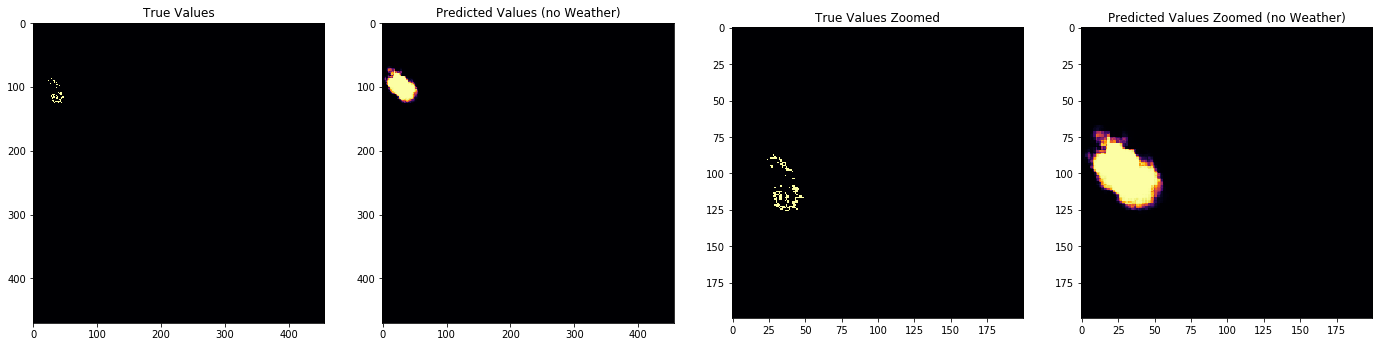

In [367]:
# show results
images_1 = [a, c, b, d]
titles_1 = ["True Values", "Predicted Values (no Weather)", "True Values Zoomed", "Predicted Values Zoomed (no Weather)"]
show_images(images_1, titles=titles_1)

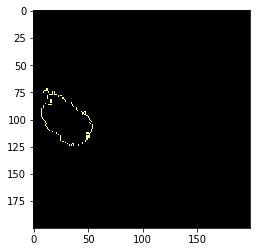

In [368]:
# get outline of fire
k = np.rint(d)
k = np.diff(k)
k = np.abs(k)
plt.imshow(k, cmap='inferno', interpolation='nearest')
plt.show()

In [ ]:
# get outline of fire
kk = np.where(d < 0.9, 0, 1)
kk = np.diff(kk)
kk = np.abs(kk)
plt.imshow(kk, cmap='inferno', interpolation='nearest')
plt.show()

### Model 2 Prediction

In [369]:
# predict fire locationf or that day using model 2
e = predict_day('140', '209', model_2, matrix_dim)

# focus more closely on prediction
f = e[0:200, 0:200]

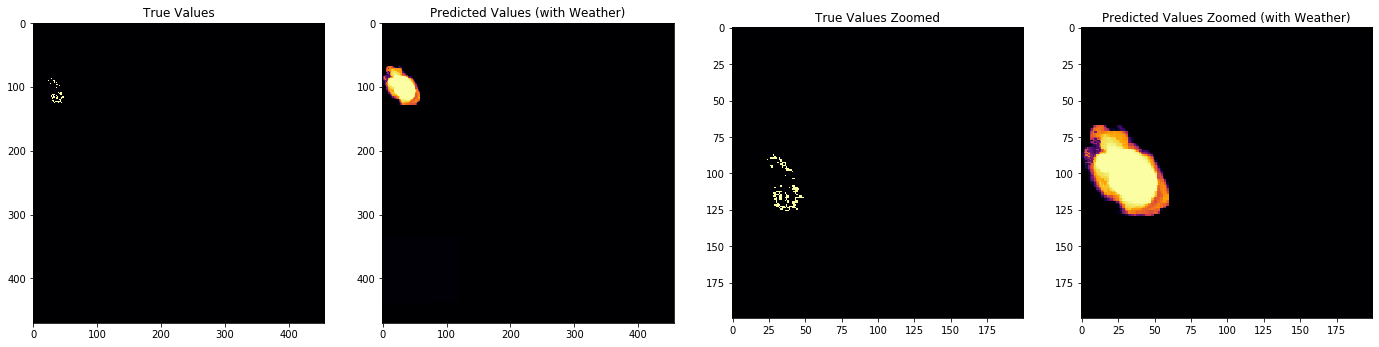

In [370]:
# show results
images_2 = [a, e, b, f]
titles_2 = ["True Values", "Predicted Values (with Weather)", "True Values Zoomed", "Predicted Values Zoomed (with Weather)"]
show_images(images_2, titles=titles_2)

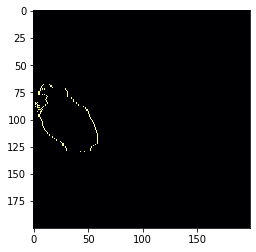

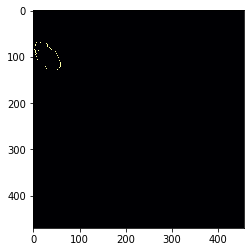

In [371]:
# get outline of fire

# zoomed
j = np.rint(f)
j = np.diff(j)
j = np.abs(j)
plt.imshow(j, cmap='inferno', interpolation='nearest')
plt.show()

# not zoomed
k = np.rint(e)
k = np.diff(k)
k = np.abs(k)
plt.imshow(k, cmap='inferno', interpolation='nearest')
plt.show()

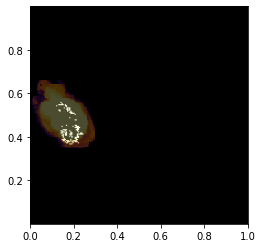

In [372]:
# overlay prediction with actual

extent = np.min(b), np.max(b), np.min(f), np.max(f)

fig = plt.figure(frameon=False)
im1 = plt.imshow(b, cmap='gray', interpolation='bilinear', extent=extent)
im2 = plt.imshow(f, cmap='inferno', interpolation='nearest', extent=extent, alpha=0.3)

plt.show()

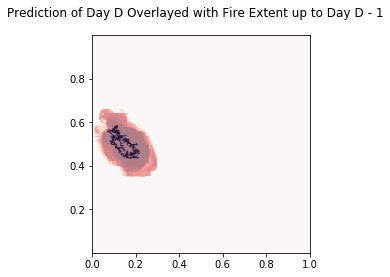

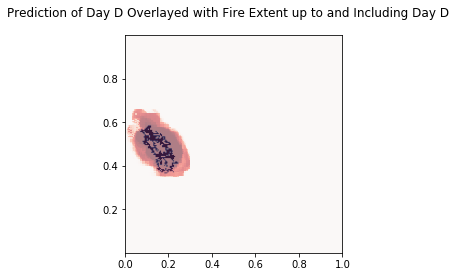

In [373]:
# overlay prediction with previous days of fire

z = fire_data_dict['140']['203'][0:200, 0:200]
y = fire_data_dict['140']['204'][0:200, 0:200]
x = fire_data_dict['140']['205'][0:200, 0:200]
v = fire_data_dict['140']['206'][0:200, 0:200]
u = fire_data_dict['140']['207'][0:200, 0:200]
t = fire_data_dict['140']['208'][0:200, 0:200]

zz = 0
zz = np.add(z, y)
zz = np.add(zz, x)
zz = np.add(zz, v)
zz = np.add(zz, u)
zz = np.add(zz, t)


extent = np.min(zz), np.max(zz), np.min(f), np.max(f)

fig2 = plt.figure(frameon=False)
fig2.suptitle("Prediction of Day D Overlayed with Fire Extent up to Day D - 1")
im_203 = plt.imshow(zz, cmap='Blues', interpolation='bilinear', extent=extent)
im_208 = plt.imshow(f, cmap='Reds', interpolation='nearest', extent=extent, alpha=0.5)
plt.show()

yy = np.add(zz, b)
fig3 = plt.figure(frameon=False)
im_act = plt.imshow(yy, cmap='Blues', interpolation='bilinear', extent=extent)
im_pred = plt.imshow(f, cmap='Reds', interpolation='nearest', extent=extent, alpha=0.5)
fig3.suptitle("Prediction of Day D Overlayed with Fire Extent up to and Including Day D")
plt.show()

### Model 3: More Data

In [223]:
def pull_data_from_s3(s3_client, bucket_name, key_name):
    '''
    Pulls pre-processed data from S3.

    Args:
        - s3_client: boto3 s3 client
        - bucket_name: name of bucket on s3 to pull data from
        - key_name: directory/file_name to pull data from
    Returns:
        - Nothing
    
    https://stackoverflow.com/questions/48049557/how-to-write-npy-file-to-s3-directly
    '''
    
    array_data = io.BytesIO()
    s3_client.download_fileobj(bucket_name, key_name, array_data)
    
    array_data.seek(0)
    array = pickle.load(array_data)

    return array

In [43]:
import boto3
import io
import pickle

s3_client = boto3.client('s3')
bucket_name = 'hotzone'

# load model from s3
new_config = pull_data_from_s3(s3_client, bucket_name, 'models/model_config.pickle')
new_weights = pull_data_from_s3(s3_client, bucket_name, 'models/model_weights.pickle')

model_3 = keras.Model.from_config(new_config)
model_3.set_weights(new_weights)

ModuleNotFoundError: No module named 'boto3'

In [ ]:
# predict fire locationf or that day using model 2
l = predict_day('140', '209', model_3, matrix_dim)

# focus more closely on prediction
m = l[0:200, 0:200]

In [ ]:
# show results
m = l[0:200, 0:200]
m = np.where(m < 0.75, 0, 1)
images_3 = [a, l, b, m]
titles_3 = ["True Values", "Predicted Values (with Weather)", "True Values Zoomed", "Predicted Values Zoomed (with Weather)"]
show_images(images_3, titles=titles_3)

In [ ]:
# get outline of fire

# zoomed
n = np.where(m < 0.9, 0, 1)
n = np.diff(n)
n = np.abs(n)
plt.imshow(n, cmap='inferno', interpolation='nearest')
plt.show()

# not zoomed
o = np.where(l < 0.9, 0, 1)
o = np.diff(o)
o = np.abs(o)
plt.imshow(o, cmap='inferno', interpolation='nearest')
plt.show()

In [ ]:
# overlay prediction with actual

extent = np.min(b), np.max(b), np.min(m), np.max(m)

fig = plt.figure(frameon=False)
im1 = plt.imshow(b, cmap='gray', interpolation='bilinear', extent=extent)
im2 = plt.imshow(m, cmap='inferno', interpolation='nearest', extent=extent, alpha=0.3)

plt.show()

In [ ]:
# overlay prediction with previous days of fire

z = fire_data_dict['140']['203'][0:200, 0:200]
y = fire_data_dict['140']['204'][0:200, 0:200]
x = fire_data_dict['140']['205'][0:200, 0:200]
v = fire_data_dict['140']['206'][0:200, 0:200]
u = fire_data_dict['140']['207'][0:200, 0:200]
t = fire_data_dict['140']['208'][0:200, 0:200]

zz = 0
zz = np.add(z, y)
zz = np.add(zz, x)
zz = np.add(zz, v)
zz = np.add(zz, u)
zz = np.add(zz, t)


extent = np.min(zz), np.max(zz), np.min(m), np.max(m)

fig2 = plt.figure(frameon=False)
fig2.suptitle("Prediction of Day D Overlayed with Fire Extent up to Day D - 1")
im_203 = plt.imshow(zz, cmap='Blues', interpolation='bilinear', extent=extent)
im_208 = plt.imshow(m, cmap='Reds', interpolation='nearest', extent=extent, alpha=0.5)
plt.show()

yy = np.add(zz, b)
fig3 = plt.figure(frameon=False)
im_act = plt.imshow(yy, cmap='Blues', interpolation='bilinear', extent=extent)
im_pred = plt.imshow(m, cmap='Reds', interpolation='nearest', extent=extent, alpha=0.5)
fig3.suptitle("Prediction of Day D Overlayed with Fire Extent up to and Including Day D")
plt.show()

In [ ]:
# predict fire locationf or that day using model 2
l = predict_day('140', '210', model_3, matrix_dim)

# focus more closely on prediction
m = l[0:200, 0:200]

In [ ]:
# show results
images_3 = [a, l, b, m]
titles_3 = ["True Values", "Predicted Values (with Weather)", "True Values Zoomed", "Predicted Values Zoomed (with Weather)"]
show_images(images_3, titles=titles_3)

In [ ]:
# get outline of fire

# zoomed
n = np.rint(m)
n = np.diff(n)
n = np.abs(n)
plt.imshow(n, cmap='inferno', interpolation='nearest')
plt.show()

# not zoomed
o = np.rint(l)
o = np.diff(o)
o = np.abs(o)
plt.imshow(o, cmap='inferno', interpolation='nearest')
plt.show()

In [ ]:
# overlay prediction with actual

extent = np.min(b), np.max(b), np.min(m), np.max(m)

fig = plt.figure(frameon=False)
im1 = plt.imshow(b, cmap='gray', interpolation='bilinear', extent=extent)
im2 = plt.imshow(m, cmap='inferno', interpolation='nearest', extent=extent, alpha=0.3)

plt.show()

In [ ]:
# overlay prediction with previous days of fire

z = fire_data_dict['140']['203'][0:200, 0:200]
y = fire_data_dict['140']['204'][0:200, 0:200]
x = fire_data_dict['140']['205'][0:200, 0:200]
v = fire_data_dict['140']['206'][0:200, 0:200]
u = fire_data_dict['140']['207'][0:200, 0:200]
t = fire_data_dict['140']['208'][0:200, 0:200]

zz = 0
zz = np.add(z, y)
zz = np.add(zz, x)
zz = np.add(zz, v)
zz = np.add(zz, u)
zz = np.add(zz, t)


extent = np.min(zz), np.max(zz), np.min(m), np.max(m)

fig2 = plt.figure(frameon=False)
fig2.suptitle("Prediction of Day D Overlayed with Fire Extent up to Day D - 1")
im_203 = plt.imshow(zz, cmap='Blues', interpolation='bilinear', extent=extent)
im_208 = plt.imshow(m, cmap='Reds', interpolation='nearest', extent=extent, alpha=0.5)
plt.show()

yy = np.add(zz, b)
fig3 = plt.figure(frameon=False)
im_act = plt.imshow(yy, cmap='Blues', interpolation='bilinear', extent=extent)
im_pred = plt.imshow(m, cmap='Reds', interpolation='nearest', extent=extent, alpha=0.5)
fig3.suptitle("Prediction of Day D Overlayed with Fire Extent up to and Including Day D")
plt.show()